# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings # Serve para ignorar mensagens de alerta que aparecem 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'lines.linewidth' : 1.5,
    'lines.markersize' : 10,
    'figure.figsize': (8,5),
    'xtick.labelsize': 12, 
    'ytick.labelsize': 12,
    'font.family': 'serif',
    'legend.fontsize':12,
    'axes.labelsize':18
})

# Importing Kuramoto dataset

We first import the solution obtained from the Kuramoto differential equation subject to periodic boundary conditions. The spatial domain has length L=200 and discretized with 256 nodes. The time step was 0.25 s with a time domain from t=0 to t=2000 s.

$$ u_t + u_x u + u_{xx} + u_{xxxx}=0 \tag{1}$$ 


$$ u(t=0,x) = cos \frac{\pi x}{20}*(1+sin\frac{\pi x}{20})  \tag{2}$$


The first 100 seconds were truncated in order to view the more chaotic part of the solution

In [4]:
X = np.load('Kuramoto_dataset\Kuramoto_X.npy')
T = np.load('Kuramoto_dataset\Kuramoto_T.npy')
U = np.load('Kuramoto_dataset\Kuramoto_U.npy')

In [5]:
X.shape

(40001, 256)

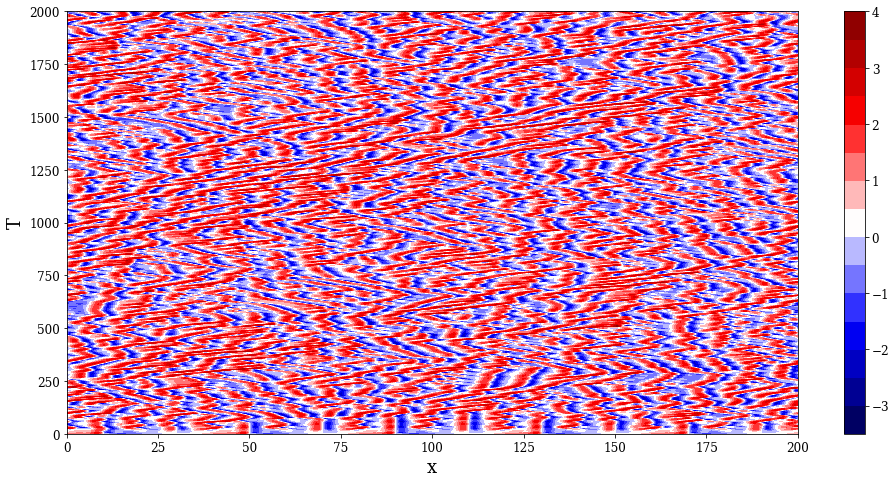

In [6]:
fig, ax = plt.subplots(figsize=(14, 7))

surf = plt.contourf(X, T, U,15, cmap=plt.get_cmap("seismic"))

plt.colorbar(surf)
plt.xlabel('x')
plt.ylabel('T')
plt.tight_layout()

In [7]:
# Taking out the first 300 seconds of data to avoid any transients

X = X[6000:]
T = T[6000:]
U = U[6000:]

## Creating the training and test set for evaluating PCA

In [8]:
# 75% training and 25% testing

X_train = X[:30000]
T_train = T[:30000]
U_train = U[:30000]

X_test = X[30000:]
T_test = T[30000:]
U_test = U[30000:]

In [9]:
print(U_train.shape)
print(U_test.shape)

(30000, 256)
(4001, 256)


In [10]:
# Normalizing the dataset to be with 0 mean and unit variance

scaler = StandardScaler()

U_scaled_train = scaler.fit_transform(U_train)
U_scaled_test = scaler.transform(U_test)

# Applying dimensionality reduction for the Kuramoto dataset

## Principal component analysis (PCA)

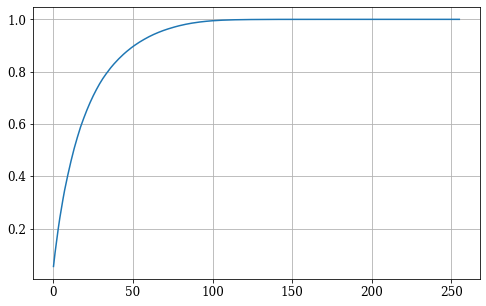

In [11]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(U_scaled_train)
cumsum = np.cumsum(pca.explained_variance_ratio_) # Cumulative sum of the variance explained by each dimension 

plt.plot(cumsum)
plt.grid()

In [12]:
d = np.argmax(cumsum >= 0.99) + 1
print(str(d) + ' components')
pca = PCA(n_components=d) # Reduce number of components from 256 to 93
U_train_pca = pca.fit_transform(U_scaled_train)
U_test_pca = pca.transform(U_scaled_test)

94 components


It turns out that I need 93 components for 99% explained variance. We reduced 256 columns to a representation with 93 eigenvectors with associated eigenvalues

In [13]:
U_train_reduced = pca.inverse_transform(U_train_pca)
U_test_reduced = pca.inverse_transform(U_test_pca)
print(U_train_reduced.shape)

U_train_reduced_inverse = scaler.inverse_transform(U_train_reduced)  # Apply inverse transform to obtain dataset in same scale as the original data
U_test_reduced_inverse = scaler.inverse_transform(U_test_reduced)

(30000, 256)


Mean absolute error (MSE): 0.09923851467241679


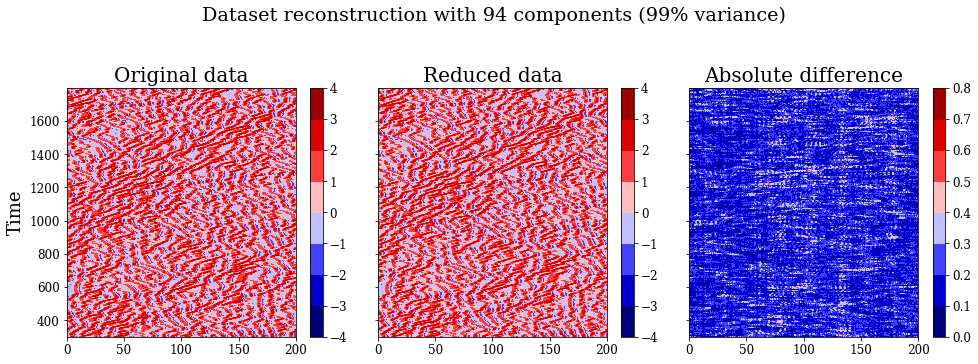

In [14]:
def plot_ROM_comparison(X,T,U,U_reduced,d=d):
    fig, ax = plt.subplots(1,3,sharey=True,figsize=(14, 5))
    plt.suptitle('Dataset reconstruction with {} components (99% variance)'.format(d), y=1.02)

    surf1 = ax[0].contourf(X, T, U, cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf1, ax=ax[0], ticks=None)
    ax[0].set_title('Original data')
    ax[0].set_ylabel('Time')

    surf2 = ax[1].contourf(X, T, U_reduced,cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf2, ax=ax[1])
    ax[1].set_title('Reduced data')

    diff =  abs(U-U_reduced)
    surf3 = ax[2].contourf(X, T, diff,cmap=plt.get_cmap("seismic")) 
    fig.colorbar(surf3, ax=ax[2])
    ax[2].set_title('Absolute difference')

    plt.tight_layout()

    print('Mean absolute error (MSE): {}'.format(diff.mean()))
    return

plot_ROM_comparison(X_train,T_train,U_train,U_train_reduced_inverse,d) # training set

Mean absolute error (MSE): 0.16873120057604213


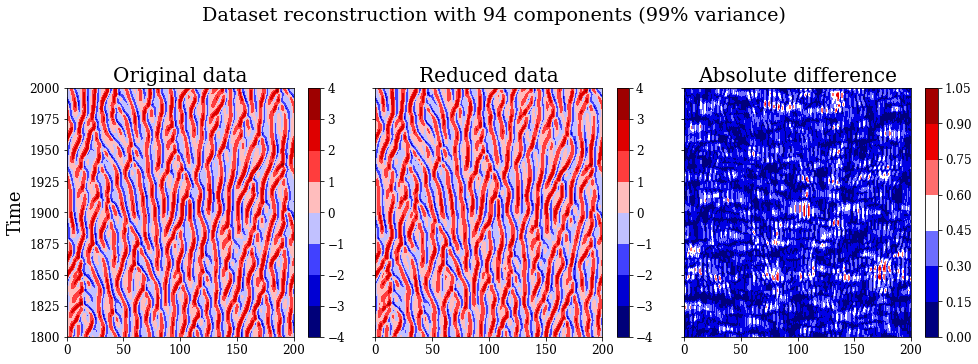

In [15]:
plot_ROM_comparison(X_test,T_test,U_test,U_test_reduced_inverse,d) # test set

Using Standardcaler: 

Training set error: 0.0992

Test ser error: 0.1686

From the above plot, we consider the precision to be sufficient for this application.

## Final ROM from Kuramoto equation

In [16]:
scaler2 = StandardScaler()
U_scaled2 = scaler2.fit_transform(U)

pca2 = PCA(n_components=d)
U_pca = pca2.fit_transform(U_scaled2)
U_pca.shape

(34001, 94)

In [17]:
df = pd.DataFrame(U_pca)
df

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,6.677109,-5.978096,2.577128,3.304686,-3.736464,-0.074265,-3.493094,1.664380,3.546049,-1.973562,...,-0.221327,-0.582646,-0.227678,1.011092,0.169502,0.510888,-1.100220,0.929156,0.609707,0.069909
1,6.682495,-5.987902,2.547367,3.372001,-3.782339,-0.075114,-3.480440,1.681142,3.513415,-1.990802,...,-0.240238,-0.580519,-0.227327,1.008787,0.185007,0.507417,-1.095969,0.921585,0.599451,0.048941
2,6.687168,-5.997976,2.518633,3.438409,-3.826708,-0.076127,-3.467654,1.697629,3.479227,-2.006757,...,-0.258648,-0.577530,-0.226911,1.006217,0.200787,0.503818,-1.091999,0.913561,0.589149,0.028621
3,6.691120,-6.008337,2.490907,3.503894,-3.869574,-0.077293,-3.454737,1.713832,3.443537,-2.021472,...,-0.276545,-0.573684,-0.226411,1.003392,0.216800,0.500117,-1.088342,0.905098,0.578790,0.008978
4,6.694344,-6.019005,2.464172,3.568447,-3.910938,-0.078604,-3.441687,1.729745,3.406396,-2.034995,...,-0.293917,-0.568986,-0.225806,1.000322,0.233003,0.496340,-1.085026,0.896211,0.568363,-0.009965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33996,2.855421,-0.621361,1.351222,-1.553371,-2.786034,-2.911797,1.980202,7.583428,-1.217830,1.964478,...,0.396939,0.956570,-0.804885,0.313524,-1.295543,-0.660122,-0.850278,-0.416860,0.176486,-0.438713
33997,2.797995,-0.619598,1.381212,-1.590193,-2.786908,-2.961349,1.987868,7.581834,-1.236074,2.007303,...,0.382886,0.950367,-0.810277,0.314719,-1.316349,-0.663681,-0.861428,-0.416275,0.168528,-0.443818
33998,2.740946,-0.617536,1.412142,-1.626961,-2.787288,-3.010079,1.996612,7.580036,-1.253666,2.048377,...,0.368564,0.943256,-0.815941,0.315697,-1.337503,-0.667192,-0.871912,-0.415327,0.160340,-0.448287
33999,2.684333,-0.615140,1.443966,-1.663629,-2.787196,-3.057906,2.006431,7.578022,-1.270522,2.087600,...,0.353986,0.935267,-0.821876,0.316458,-1.358932,-0.670679,-0.881704,-0.414057,0.151942,-0.452127


# Plotting a sample of all time series

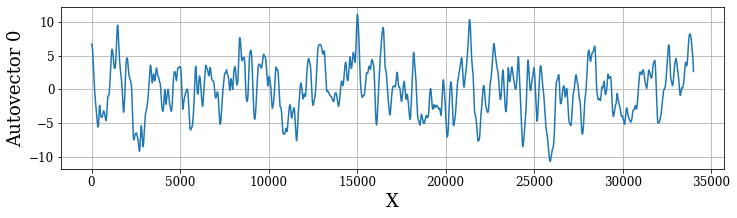

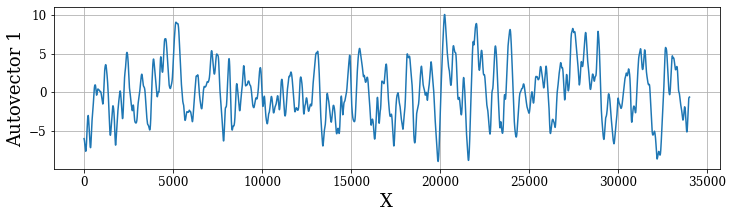

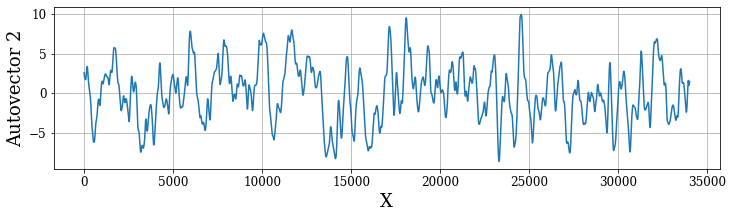

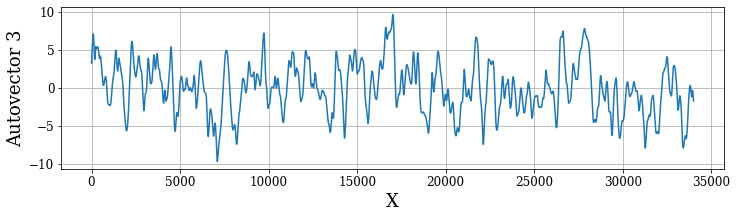

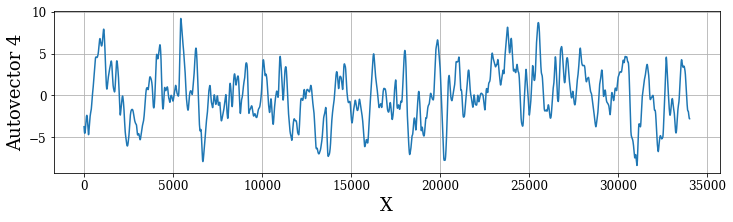

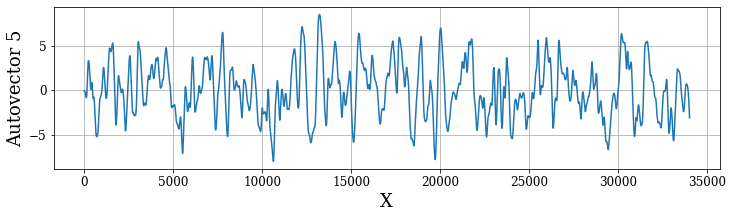

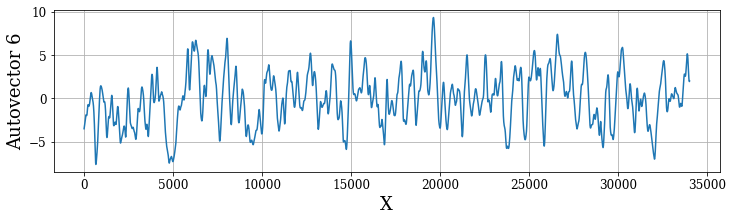

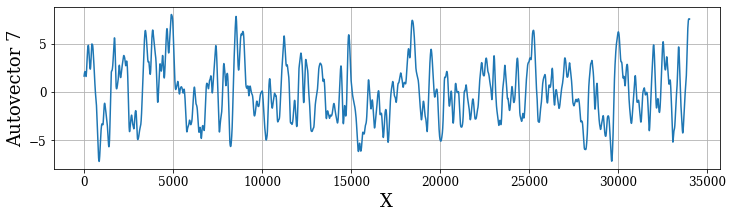

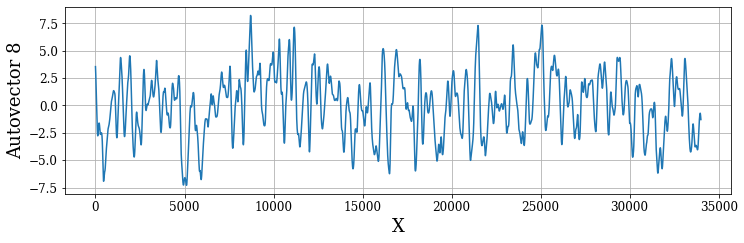

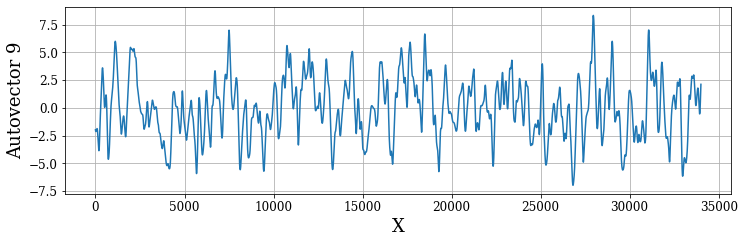

In [18]:
plt.rcParams.update({'figure.figsize': (20, 15)})

for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(df[df.columns[i]], label = df.columns[i])
    
    plt.xlabel('X')
    plt.ylabel('Autovector ' + str(df.columns[i]))
    plt.tight_layout()
    plt.grid()
    plt.show()

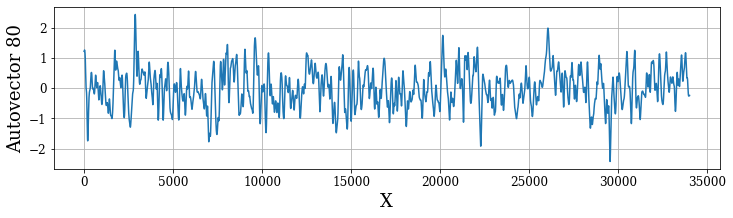

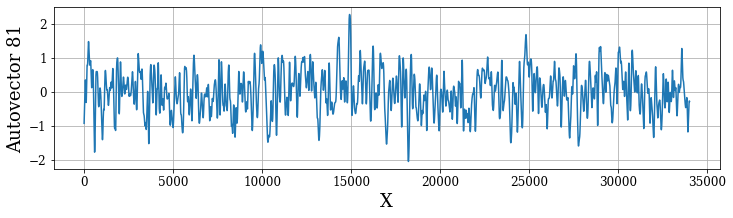

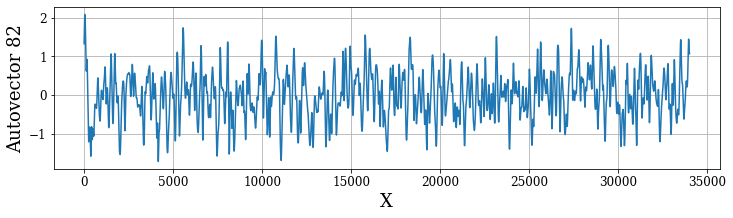

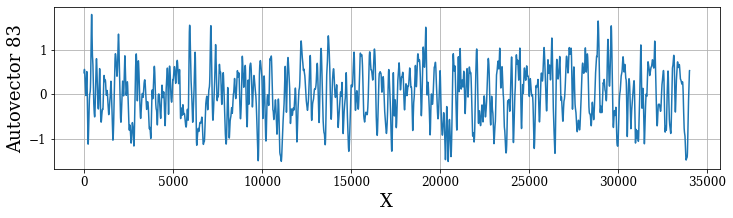

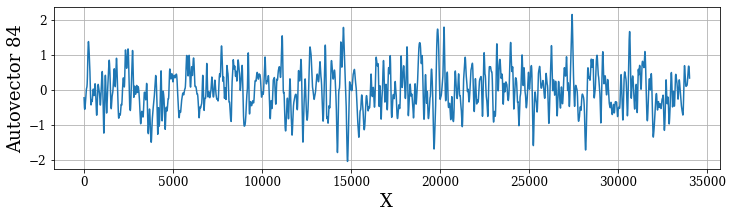

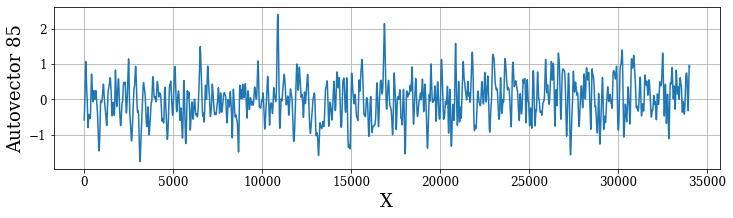

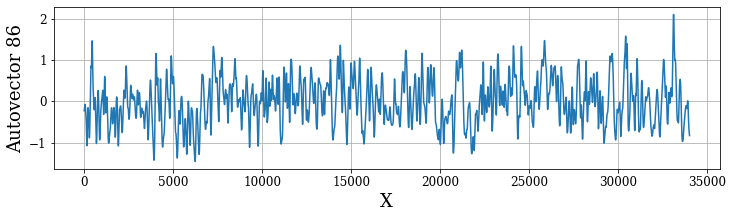

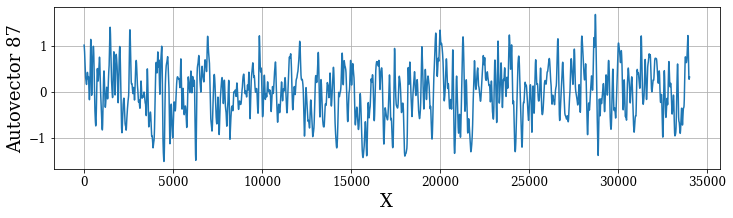

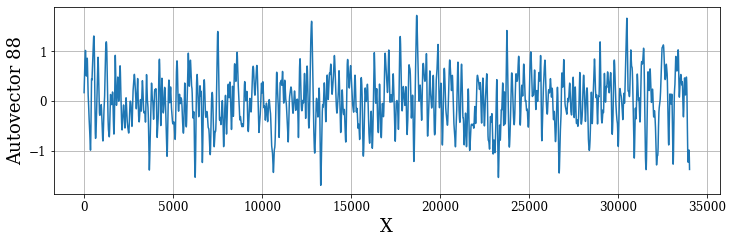

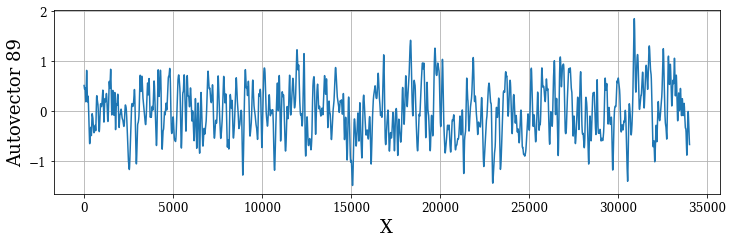

In [19]:
plt.rcParams.update({'figure.figsize': (20, 15)})

for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.plot(df[df.columns[i+80]], label = df.columns[i])
    
    plt.xlabel('X')
    plt.ylabel('Autovector ' + str(df.columns[i+80]))
    plt.tight_layout()
    plt.grid()
    plt.show()

The time series seem to be random values around 0. Is there some pattern in this data? If so, the selection of forecasting model would be easier.

We can see that the amplitude of the first few time series (which corresponds to the most important eigenvectors) have larger amplitude and lower frequency compared last eigenvectors (lower amplitude/energy and higher frequency).

# Statistical analysis of time series 

Statistical analysis has the objective of better understanding the behavior of our time series in order to better define our model

## Dickey-Fuller Test - visualize stationarity

This is the statistical test that we run to determine if a time series is stationary or not. Without going into the technicalities of the Dickey-Fuller test, it tests the null hypothesis that a unit root is present.

- If it is, then p > 0.05, and the process is not stationary.
- Otherwise, p < 0.05, the null hypothesis is rejected, and the process is considered to be stationary.

When the test statistic is lower than the critical value shown, you reject the null hypothesis and infer that the time series is stationary.

In [20]:
import statsmodels
from statsmodels.tsa.stattools import adfuller

In [21]:
# Augmented Dickey-Fuller Test

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='t-stat')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Lags used = {:.3f}'.format(dftest[2]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

for i in range(10):
    ADF_test(df[df.columns[i]],'Autovector ' + str(i))
    print('')

 > Is the Autovector 0 stationary?
Test statistic = -0.003
P-value = 0.958
Lags used = 10.000
Critical values :
	1%: -3.430542403469252 - The data is not stationary with 99% confidence
	5%: -2.8616250374992855 - The data is not stationary with 95% confidence
	10%: -2.566815262802058 - The data is not stationary with 90% confidence

 > Is the Autovector 1 stationary?
Test statistic = -3.030
P-value = 0.032
Lags used = 8.000
Critical values :
	1%: -3.430542392147882 - The data is not stationary with 99% confidence
	5%: -2.8616250324956867 - The data is  stationary with 95% confidence
	10%: -2.5668152601387706 - The data is  stationary with 90% confidence

 > Is the Autovector 2 stationary?
Test statistic = -0.192
P-value = 0.939
Lags used = 8.000
Critical values :
	1%: -3.430542392147882 - The data is not stationary with 99% confidence
	5%: -2.8616250324956867 - The data is not stationary with 95% confidence
	10%: -2.5668152601387706 - The data is not stationary with 90% confidence

 > I

In [22]:
# Visualizing stationarity for the least important eigenvectors
for i in range(10):
    ADF_test(df[df.columns[i+80]],'Autovector' + str(i+80))
    print('')

 > Is the Autovector80 stationary?
Test statistic = -0.433
P-value = 0.904
Lags used = 9.000
Critical values :
	1%: -3.430542397808401 - The data is not stationary with 99% confidence
	5%: -2.8616250349974126 - The data is not stationary with 95% confidence
	10%: -2.566815261470375 - The data is not stationary with 90% confidence

 > Is the Autovector81 stationary?
Test statistic = -0.170
P-value = 0.942
Lags used = 9.000
Critical values :
	1%: -3.430542397808401 - The data is not stationary with 99% confidence
	5%: -2.8616250349974126 - The data is not stationary with 95% confidence
	10%: -2.566815261470375 - The data is not stationary with 90% confidence

 > Is the Autovector82 stationary?
Test statistic = -0.225
P-value = 0.936
Lags used = 9.000
Critical values :
	1%: -3.430542397808401 - The data is not stationary with 99% confidence
	5%: -2.8616250349974126 - The data is not stationary with 95% confidence
	10%: -2.566815261470375 - The data is not stationary with 90% confidence

 

We can see that our dataset contains only mostly stationary signals. If traditional time series forecasting algorithms are to be used, they must be the ones that deal with non stationary signals like ARIMA (Autoregressive Integrated Moving Average) or SARIMA (Seasonal Autoregressive Integrated Moving Average). 

Machine learning algorithms should also be able to deal with non stationary signals without having to worry about this type of data preprocessing.

## Detecting the presence of white noise

A time series can be summarized by the following formula:

y(t) = signal(t) + noise(t)

It is expected that a time series signal contains white noise. Therefore, it is an important concept for time series analysis to confirm if the signal has this for two main reasons:

- **Predictability:** if the time series is white noise, then it is, by definition, random. You cannot reasonably model it and make predictions
- **Model diagnostics:** The errors of a model should, ideally be white noise. This means that all signal information in the time series has been harnessed by the model in order to make the predictions. If the model output is not white noise, it is an indication that further improvements can be made. 

The time series in not white noise if any of the following conditions are true:

- Time series have non-zero mean;
- The variance change over time;
- There exists correlation with lag values.

In [23]:
df.mean()

0     9.077047e-16
1    -3.221217e-16
2     6.990216e-16
3     7.989844e-16
4    -6.173050e-16
          ...     
89    6.387056e-16
90    1.684191e-16
91    3.989828e-16
92    6.350860e-17
93    4.546621e-16
Length: 94, dtype: float64

The time series appear to all have zero mean. The standard deviation case is harder to do so lets look at the lag values and visualize autocorrelation

In [24]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm

For random data, autocorrelations should be near zero for all lags. Analysts also refer to this condition as white noise. Non-random data have at least one significant lag. When the data are not random, it’s a good indication that you need to use a time series analysis or incorporate lags into a regression analysis to model the data appropriately. 

Looking again into stationarity, our signal must:

- Not have a trend (mean=0);
- Have constant variance; 
- Have a constant autocorrelation pattern (below the confidence interval);
- Have no seasonal pattern. 

The autocorrelation function (ACF) declines to near zero rapidly for a stationary time series. In contrast, the ACF drops slowly for a non-stationary time series (our case it take 300 lags). There is also no seasonal components since there are no repetitive peaks at defined multiples. Overall, the adf test hypothesis of non stationarity was also shown here in the acf and pacf plots

The confidence interval of 95% is represented by the shaded cone. Values outside the cone suggest very likely correlation and not a statistical fluke. Looks like only first lags have autocorrelation. 

Source: https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/ 

In [25]:
def plot_autocorrelation(df,i=0):
    fig, ax = plt.subplots(1,2,figsize=(25, 5))
    
    plot_acf(df[df.columns[i]],lags=len(df)-1,ax=ax[0]);
    ax[0].set_title('Autocorrelation - Eigenvector ' + str(i))
    ax[0].set_xlabel('Number of lags')
    ax[0].set_ylabel('Pearson coefficient')
    ax[0].grid()

    plot_pacf(df[df.columns[i]], lags=20,method='ywmle',alpha=.5,ax=ax[1])
    ax[1].set_title('Partial autocorrelation - Eigenvector ' + str(i))
    ax[1].set_xlabel('Number of lags')
    ax[1].set_ylabel('Pearson coefficient for residual')
    ax[1].grid()
    return

Let us now take a closer look at the partial autocorrelation (PACF). Instead of finding correlations of present values with lags like ACF, PACF finds correlation of the residuals with the next lag. It is a function that measures the incremental benefit of adding another lag. So if through the PACF function we discover that there is hidden information in the residual that can be modeled by the next lag, we might get a good correlation, and we will keep that next lag as a feature while modeling.

As mentioned before, an autoregression is a model based on the assumption that present values of a time series can be obtained using previous values of the same time series: the present value is a
weighted average of its past values. In order to avoid multicollinear features for time series models, it is necessary to find optimum features or order of the autoregression process using the PACF
plot, as it removes variations explained by earlier lags, so we get only the relevant features.

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


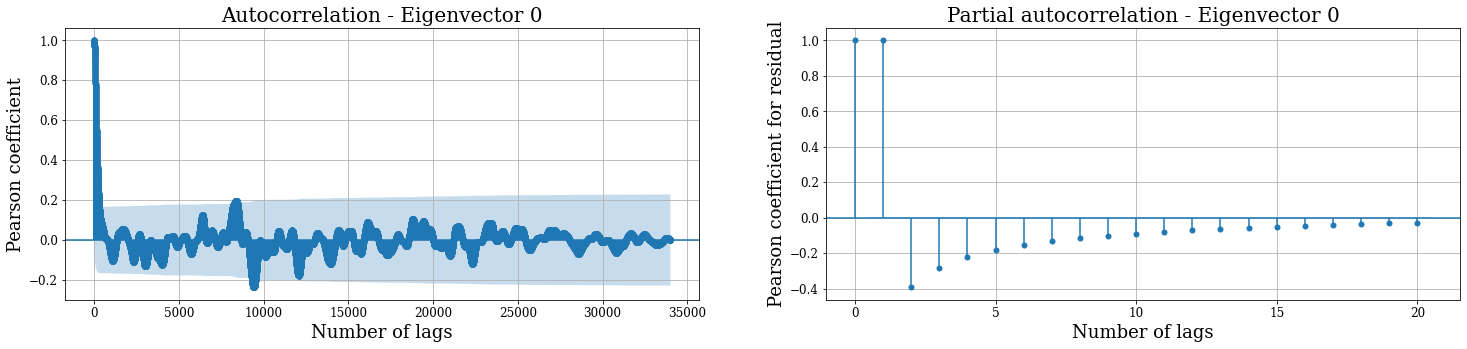

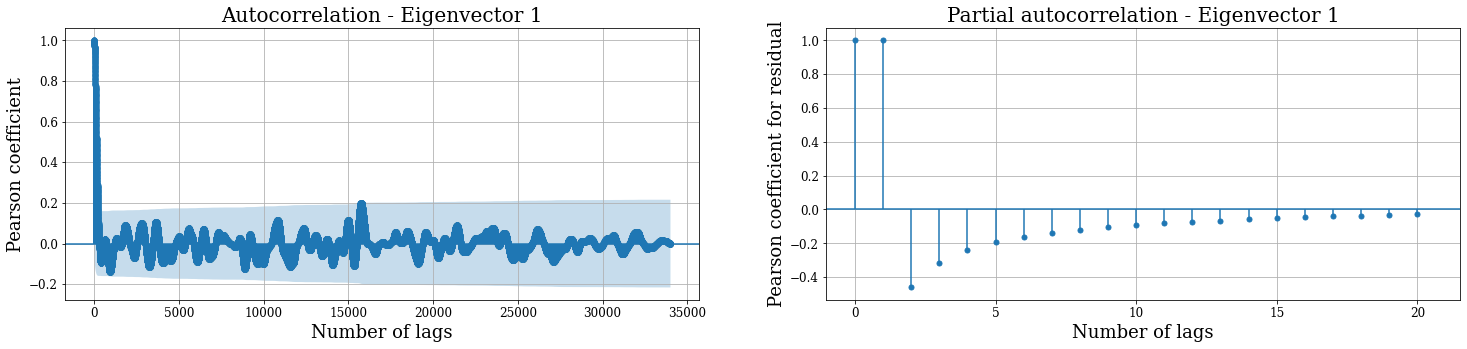

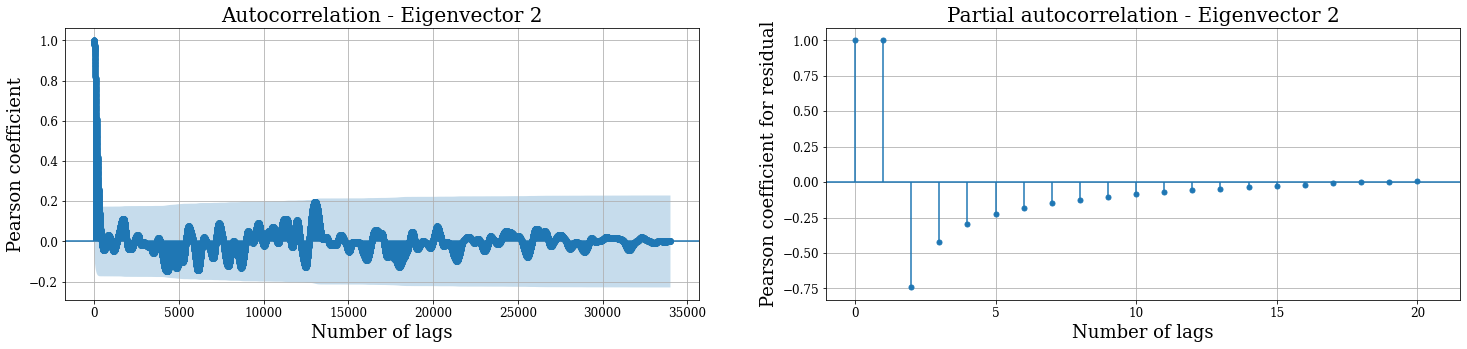

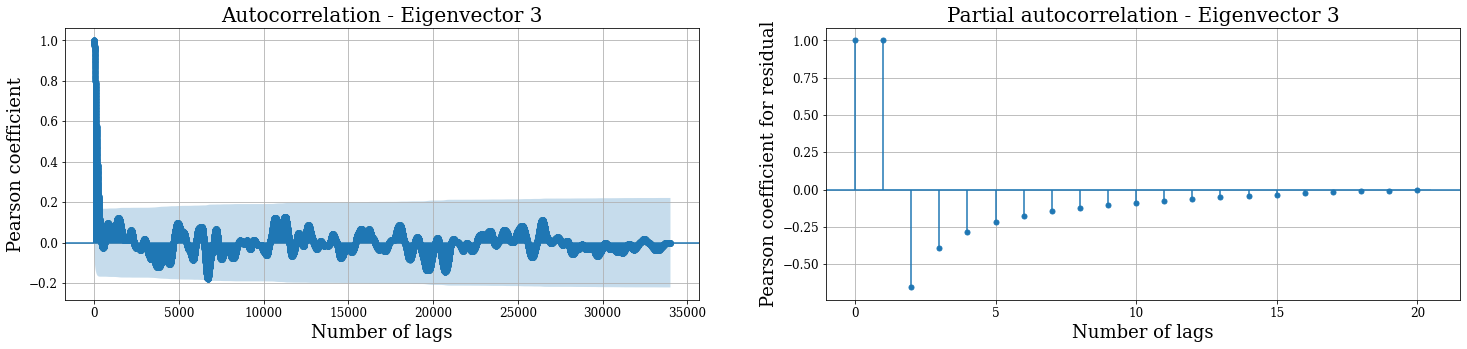

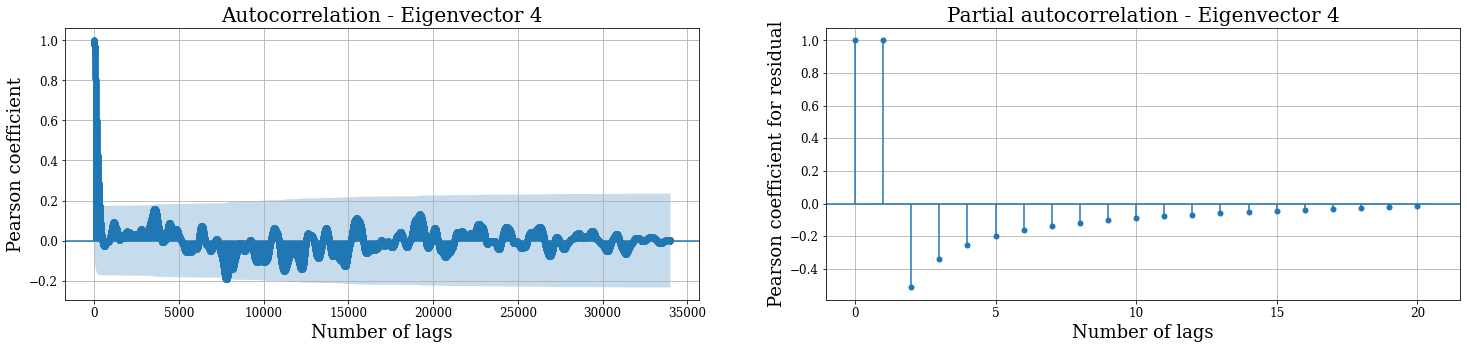

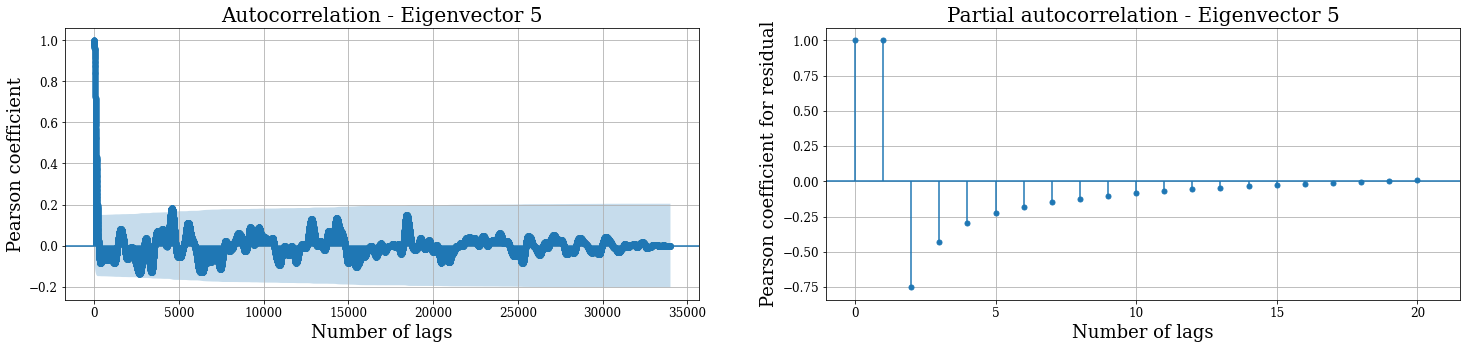

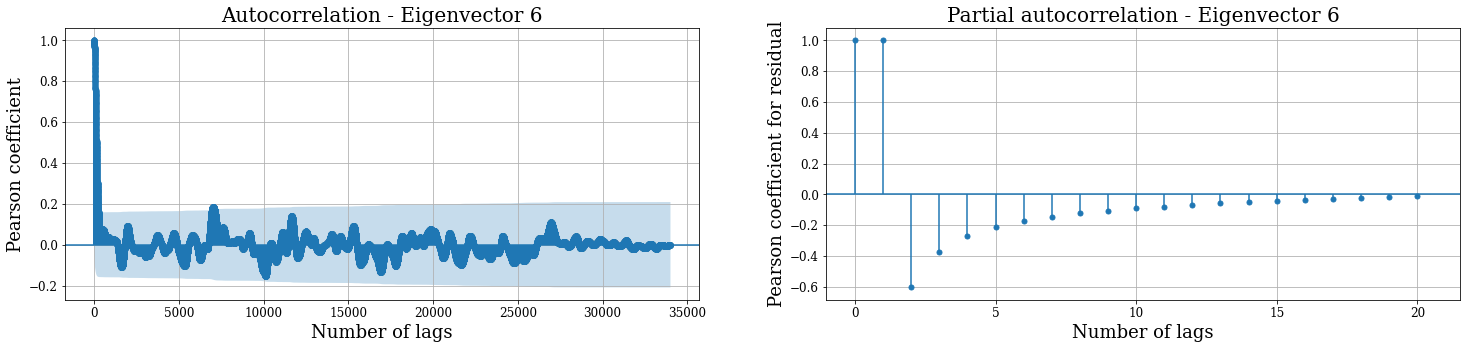

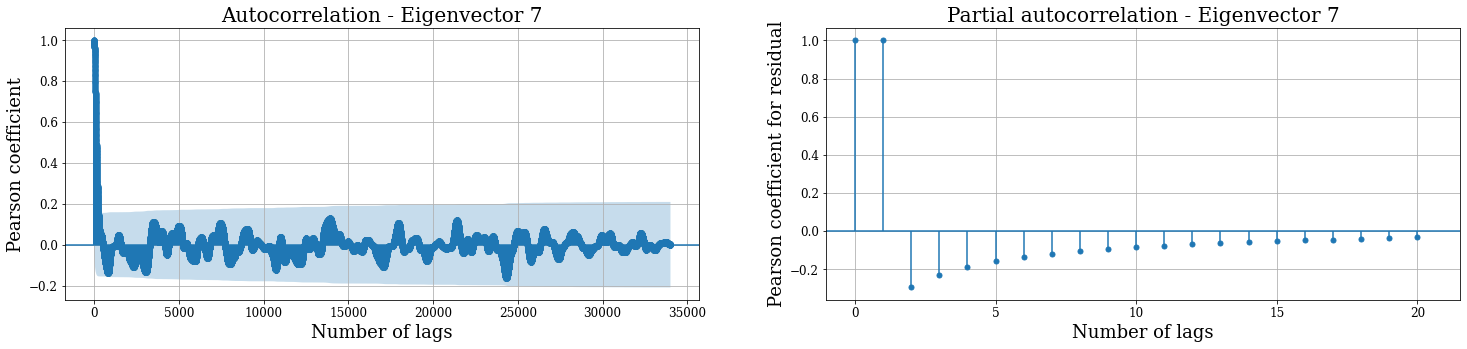

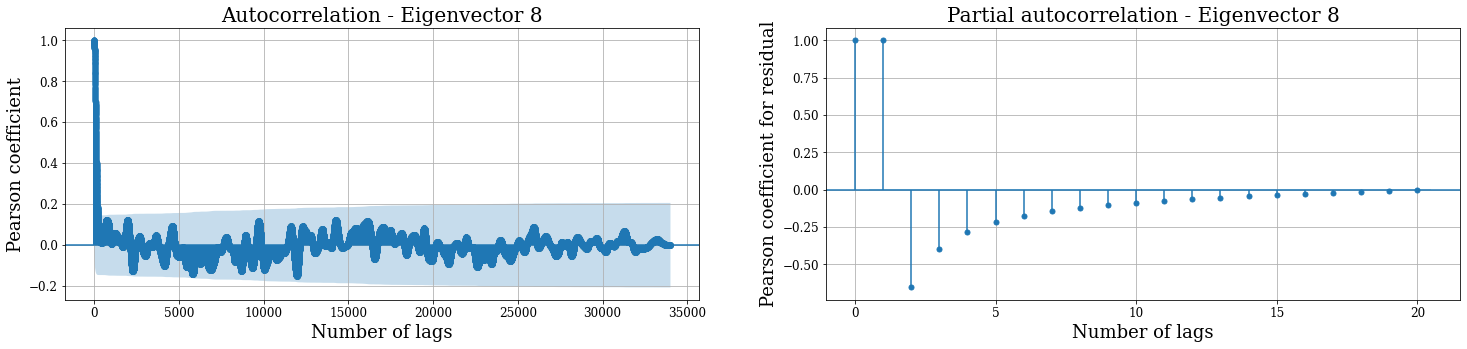

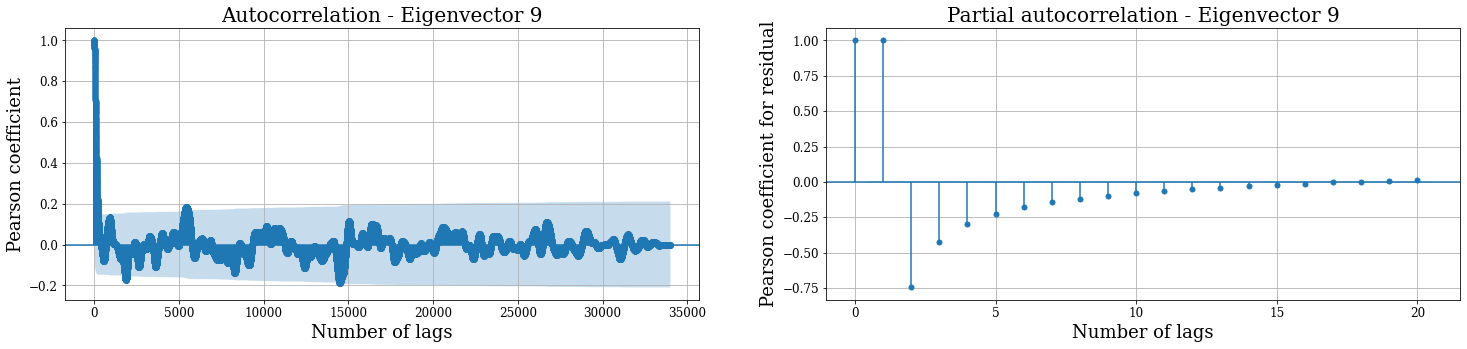

In [26]:
for i in tqdm(range(10)):
    plot_autocorrelation(df,i)

From the partial autocorrelation plots, the most extreme lag that can be used a predictor would a lag between 1 and 5 based on the Pearson coefficient. Remember that this is just a bivariate correlation. Maybe the other lag terms are important due to its multivariable correlation with the target. 

Also, the cone of 95% is very small in the PACF plot. This leads us to believe that many lag components have some correlation, even though is miniscule. Since it is miniscule, they can also be ignored. 

Source: 
- https://www.linkedin.com/pulse/how-use-machine-learning-time-series-forecasting-vegard-flovik-phd-1f/
- https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424
- Book: Machine learning for time series forecasting with Python - Francesca Lazzeri (for explaining PACF and ACF)
- https://stats.stackexchange.com/questions/226468/how-many-lags-should-i-include-in-time-series-prediction 


Another important thing to note is the really high correlation at lag 1. This means that we can use the value at time "t" as the prediction for "t+1", meaning that our machine learning algorithm will not learn anything useful from training or the historical data. A possibility is to use a model to predict the difference in values between time steps instead of the value itself. This is a much stronger test of the models predictive power.

Therefore, one of the "dangers" of working with non stationary time series is the autocorrelation leading to high model performance metrics but not helping the forecasting step at all. If a bug appears down the line, this procedure could provide a more robust model

# Creating the dataset for typical ML models

We must frame our time series forecasting problem as a supervised learning problem. Given an input dataset **X** and an output variable **y**, we will try to find a mapping function from the input to the output. This involves using the value at previous time steps to predict the value at the next time step.

To do so, our dataset **X** must be the data as a previous time step while **y** must be the data at the next time step. The order between observations must be conserved since the order matters. The definition of "next time step" must also be studied. Should we use one step into the future? Maybe the model is still accurate for 41 time steps into the future? Who nows? We must test this to see when model accuracy starts to drop. 

Note that we are working with a **multivariate time series**, meaning that two or more variables (eigenvectors in this case) are observed at each time. In this specific case, we are working with PCA components. Due to there property of orthogonality, each of the 93 eigenvector time series are linearly independent (uncorrelated) with one another. This is a necessary condition for independence, but not a sufficient condition since higher order dependence may exist (which we will ignore). Due to this, we assume that this is enough to state that one time series **WILL NOT** influence the other.

## Granger causality test - see if one time series helps predict the other

**Basic intuition**

Consider two time series named x and y. This test serves the purpose of seeing if time series x can be used to predict time series y **BETTER** than the actual autoregressive terms of y. If you do an autoregression (AR) of time series x, you will get a certain error over time. If now you do an autoregression of time series x that also uses terms of y (bivariate autoregression), does the error decrease?

- If the time series are independent, no correlation exists and the bivariate autoregression turn into univariate since the error didn't change. 
- If the time series have correlation (predict x from previous values of y), the error decreases since the fit of the bivariate model is better than the univariate model.

- If there is no correlation, GC (Granger causality) index = 0 (same error variance)
- If there is some correlation, GC > 0
- GC < 0 should not happen (represents terrible fit or error in the dataset)

We calculate Granger Causality with a sliding window of the entire signal. There are 2 important hyperparameters:

- Time window: Consider stationary time windows
- Model order: 

Source: 
https://www.youtube.com/watch?v=XqsSB_vpHLs&ab_channel=MikeXCohenMikeXCohen 

https://www.youtube.com/watch?v=51Yy11Vy_4Y&ab_channel=AIEngineering 

In [27]:
from statsmodels.tsa.stattools import grangercausalitytests
# This will be implemented for two different time series. From these two time series, 
# we will conclude if there is some type of dependence between the time series

series1 = df[0]
series2 = df[1]

## Now actually creating the dataset

In [28]:
def create_dataset(df,series_column_name,nlags=5,HORIZON=50):
    df_series = pd.DataFrame(df[series_column_name]) # Selecting one time series from the dataframe
    df_series.columns=['t']
    
    for k in range(1,nlags): # Create input dataset with lagged features
        label = 't-' + str(k)
        df_series[label] = df_series['t'].shift(k) # lag column of value k
    
    
    df_series['t+' + str(HORIZON-1)] = df_series['t'].shift(-HORIZON)
    
    df_series.dropna(inplace=True)
    return df_series

dataframe = create_dataset(df,25,nlags=6,HORIZON=60)
dataframe.tail(10)

,t,t-1,t-2,t-3,t-4,t-5,t+59
33931,-0.220362,-0.221684,-0.223461,-0.225696,-0.228389,-0.231540,-0.626649
33932,-0.219492,-0.220362,-0.221684,-0.223461,-0.225696,-0.228389,-0.631223
33933,-0.219069,-0.219492,-0.220362,-0.221684,-0.223461,-0.225696,-0.635156
33934,-0.219086,-0.219069,-0.219492,-0.220362,-0.221684,-0.223461,-0.638414
33935,-0.219537,-0.219086,-0.219069,-0.219492,-0.220362,-0.221684,-0.640963
33936,-0.220415,-0.219537,-0.219086,-0.219069,-0.219492,-0.220362,-0.642775
33937,-0.221711,-0.220415,-0.219537,-0.219086,-0.219069,-0.219492,-0.643819
33938,-0.223418,-0.221711,-0.220415,-0.219537,-0.219086,-0.219069,-0.644071
33939,-0.225529,-0.223418,-0.221711,-0.220415,-0.219537,-0.219086,-0.643508
33940,-0.228034,-0.225529,-0.223418,-0.221711,-0.220415,-0.219537,-0.642112


In [29]:
dataframe_train = dataframe[:30000]
dataframe_test = dataframe[30000:]
print('Training dataframe shape: ', dataframe_train.shape)
print('Test dataframe shape: ', dataframe_test.shape) # 11% of the dataset is separated for testing

Training dataframe shape:  (30000, 7)
Test dataframe shape:  (3936, 7)


# Training traditional ML algorithms - test 1

PyCaret Regression Module is a supervised machine learning module used for estimating the relationships between a dependent variable (often called the ‘outcome variable’, or ‘target’) and one or more independent variables (often called ‘features’, or ‘predictors’).

In [30]:
from pycaret.regression import *

clf1 = setup(data = dataframe_train,
             test_data = dataframe_test, 
             target = dataframe_train.columns[-1], 
             data_split_shuffle = False,
             use_gpu = True,
             fold_strategy = 'timeseries',
             preprocess = False,
             fold = 5,
             silent=True,
             session_id = 123) # testing for predicting one time series

,Description,Value
0,session_id,123
1,Target,t+59
2,Original Data,"(30000, 7)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,0
6,Transformed Train Set,"(30000, 6)"
7,Transformed Test Set,"(3936, 6)"
8,Shuffle Train-Test,False
9,Stratify Train-Test,False


In [31]:
models() # display models used by pycaret

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


### Training the models 

In [32]:
# Training all models from the above list with the exception of three and get the best 3
top = compare_models(sort = 'MAE',
                      exclude=['lar','ada','knn','llar','rf','par','xgboost','lightgbm'],
                      n_select = 1) 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.2330,0.0905,0.2996,0.9730,0.1379,1.0239,0.0320
lr,Linear Regression,0.2557,0.1114,0.3305,0.9661,0.1493,1.1264,0.0080
huber,Huber Regressor,0.4187,0.2878,0.5347,0.9138,0.2315,2.1142,0.0700
ridge,Ridge Regression,0.6876,0.7531,0.8581,0.7813,0.3421,3.6451,0.0080
et,Extra Trees Regressor,0.8784,1.1943,1.0870,0.6446,0.4156,5.4198,3.1940
gbr,Gradient Boosting Regressor,0.9159,1.3157,1.1375,0.6150,0.4285,4.1119,2.1700
dt,Decision Tree Regressor,1.0574,1.7173,1.3069,0.4825,0.4683,6.5964,0.1040
omp,Orthogonal Matching Pursuit,1.0596,1.7714,1.3209,0.4785,0.4888,4.1491,0.0080
en,Elastic Net,1.1273,2.0208,1.4079,0.4107,0.5434,3.2241,0.0260
lasso,Lasso Regression,1.1971,2.3030,1.4980,0.3344,0.6065,2.6251,0.0080


In [33]:
prediction_holdout = predict_model(top); # check score against the test set

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.2785,0.1289,0.3591,0.9621,0.1657,1.1866


In [34]:
# Hyperparameter tuning

#tuned_top = tune_model(top,
#                       n_iter = 500,
#                       search_library='optuna',
#                       search_algorithm='tpe',
#                       early_stopping_max_iters=10,
#                       early_stopping=True,
#                       optimize = 'MAE')

In [35]:
print(top)
#print(tuned_top)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)


In [36]:
# generate predictions for the entire dataset
predictions = predict_model(top, data=dataframe)
predictions['time_step'] = predictions.index - predictions.index.min() + 1
predictions

,t,t-1,t-2,t-3,t-4,t-5,t+59,Label,time_step
5,-2.066628,-2.068970,-2.069156,-2.067175,-2.063019,-2.056684,0.665554,0.236143,1
6,-2.062147,-2.066628,-2.068970,-2.069156,-2.067175,-2.063019,0.729834,0.243219,2
7,-2.055544,-2.062147,-2.066628,-2.068970,-2.069156,-2.067175,0.793863,0.364507,3
8,-2.046842,-2.055544,-2.062147,-2.066628,-2.068970,-2.069156,0.857571,0.426574,4
9,-2.036065,-2.046842,-2.055544,-2.062147,-2.066628,-2.068970,0.920889,0.495008,5
...,...,...,...,...,...,...,...,...,...
33936,-0.220415,-0.219537,-0.219086,-0.219069,-0.219492,-0.220362,-0.642775,-0.646897,33932
33937,-0.221711,-0.220415,-0.219537,-0.219086,-0.219069,-0.219492,-0.643819,-0.674641,33933
33938,-0.223418,-0.221711,-0.220415,-0.219537,-0.219086,-0.219069,-0.644071,-0.720039,33934
33939,-0.225529,-0.223418,-0.221711,-0.220415,-0.219537,-0.219086,-0.643508,-0.735601,33935


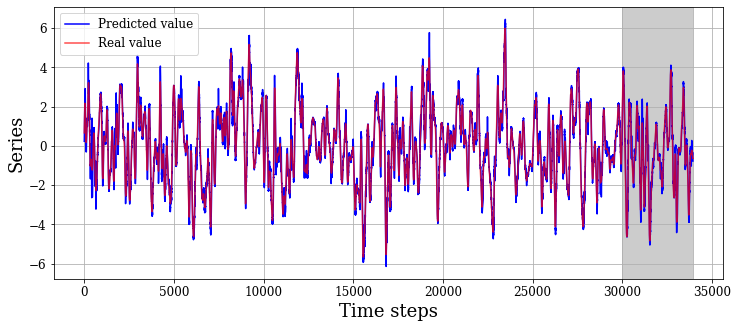

In [37]:
plt.figure(figsize=(12,5))
plt.plot(predictions.time_step,predictions['Label'],color='blue',label='Predicted value')
plt.plot(predictions.time_step,predictions[dataframe.columns[-1]],color='red',alpha=0.7,label='Real value')
plt.xlabel('Time steps')
plt.ylabel('Series')
plt.legend()
plt.grid()

# add a vertical rectange for test-set separation
plt.axvspan(xmin=dataframe_test.index[0], xmax = dataframe_test.index[-1],color='grey',alpha=0.4)

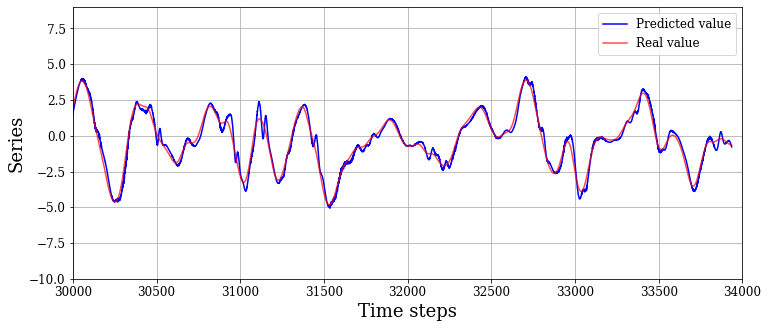

In [38]:
# test set plot

plt.figure(figsize=(12,5))
plt.plot(predictions.time_step,predictions['Label'],color='blue',label='Predicted value')
plt.plot(predictions.time_step,predictions[dataframe.columns[-1]],color='red',alpha=0.7,label='Real value')
plt.xlabel('Time steps')
plt.ylabel('Series')
plt.legend()
plt.xlim([30000,34000])
plt.ylim([-10,9])
plt.grid()

The model can accuratly forecast the trend of the time series, however, it has dificulty in modeling fast local changes. It even looks like a smoothed version of the original series.

# Training all time series

In [39]:
all_results = [] # Save the MAE result for each HORIZON value to determine how far we can forecast
final_model = {}

def train_all_time_series(df,nlags,HORIZON):

    # Create the 93 time series models
    for i in tqdm(range(len(df.columns))):
        dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON) 

        dataframe_train = dataframe[:30000]
        dataframe_test = dataframe[30000:]    
        
        s = setup(data = dataframe_train,
                     test_data = dataframe_test, 
                     target = dataframe_train.columns[-1], 
                     data_split_shuffle = False,
                     use_gpu = True,
                     fold_strategy = 'timeseries',
                     preprocess = False,
                     fold = 5,
                     silent=True,
                     session_id = 123,
                     verbose=False) # testing for predicting one time series
        
    # Teste and compare different ML models
        best_model = compare_models(sort = 'MAE',
                                    exclude=['lar','ada','knn','llar','rf','par','xgboost','lightgbm','en','et'],
                                    n_select = 1,
                                    verbose=False) 
    
    # Hyperparameter tuning with optuna 
        best_model_tuned = tune_model(best_model, 
                                      n_iter = 100,
                                      search_library='optuna',
                                      #search_algorithm='tpe',
                                      early_stopping_max_iters=15,
                                      early_stopping=True,
                                      optimize = 'MAE',
                                      verbose=False,
                                      choose_better=True)
    
    
        # capture the compare result grid and store best model in list
        p = pull().iloc[0:1]
        p['time_series'] = str(i)
        all_results.append(p)
    
        f = finalize_model(best_model_tuned) # finalize model i.e fit on entire dataset including test set
        final_model[i] = f # Attach final model to a dictionary
        save_model(f, model_name='trained_models/' + str(i), verbose=False) # pickle the trained model into this folder
    
# Source: https://towardsdatascience.com/multiple-time-series-forecasting-with-pycaret-bc0a779a22fe 

In [40]:
NLAGS = 6 # From analyzing the PACF plot, this value was chosen. 
HORIZON = 70 # Predict `HORIZON` time steps into the future
train_all_time_series(df,nlags=NLAGS,HORIZON=HORIZON)

# https://www.youtube.com/watch?v=_ZQ-lQrK9Rg&ab_channel=CodeEmporium 

100%|██████████| 94/94 [11:14:22<00:00, 430.45s/it]


In [41]:
# Display the best model selected for each time series.

concat_results = pd.concat(all_results,axis=0)
concat_results.head(10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,time_series
0,0.3985,0.2510,0.5010,0.9708,0.1761,1.0740,0
0,0.2980,0.1413,0.3759,0.9862,0.1404,0.4648,1
0,0.3356,0.1913,0.4373,0.9785,0.1612,0.4455,2
0,0.3491,0.2039,0.4515,0.9826,0.1748,1.4765,3
0,0.3443,0.2318,0.4815,0.9725,0.1811,2.1260,4
0,0.3464,0.1868,0.4322,0.9745,0.1662,0.8591,5
0,0.3542,0.2016,0.4490,0.9835,0.1582,0.9585,6
0,0.3333,0.1823,0.4270,0.9778,0.1756,1.1104,7
0,0.3517,0.2067,0.4547,0.9764,0.1598,1.3824,8
0,0.3072,0.1684,0.4104,0.9717,0.1611,0.7506,9


In [42]:
# Now let’s create a loop to load the trained pipelines and use the predict_model function to generate prediction labels.

all_score_df = []

for i in tqdm(range(df.shape[1])):
    l = load_model('trained_models/' + str(i), verbose=False)
    
    dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON) 
    dataframe_train = dataframe[:30000]
    dataframe_test = dataframe[30000:]        
    
    p = predict_model(l, data=dataframe_test)
    all_score_df.append(p)

concat_df = pd.concat(all_score_df, axis=1)
print(concat_df.shape)
concat_df.head(10)

100%|██████████| 94/94 [00:10<00:00,  8.76it/s]

(3926, 752)


,t,t-1,t-2,t-3,t-4,t-5,t+69,Label,t,t-1,...,t+69,Label,t,t-1,t-2,t-3,t-4,t-5,t+69,Label
30005,-4.206961,-4.198675,-4.190419,-4.182189,-4.173985,-4.165803,-4.993025,-4.045229,-0.868147,-0.854608,...,-0.146213,-0.064960,-0.872288,-0.873933,-0.875526,-0.877077,-0.878599,-0.880099,-0.277570,-0.361511
30006,-4.215278,-4.206961,-4.198675,-4.190419,-4.182189,-4.173985,-5.005323,-4.278318,-0.882053,-0.868147,...,-0.152422,0.246139,-0.870578,-0.872288,-0.873933,-0.875526,-0.877077,-0.878599,-0.264919,-0.296615
30007,-4.223630,-4.215278,-4.206961,-4.198675,-4.190419,-4.182189,-5.017433,-3.983188,-0.896267,-0.882053,...,-0.158929,-0.085441,-0.868790,-0.870578,-0.872288,-0.873933,-0.875526,-0.877077,-0.252390,-0.407243
30008,-4.232021,-4.223630,-4.215278,-4.206961,-4.198675,-4.190419,-5.029337,-4.190625,-0.910732,-0.896267,...,-0.165723,0.159165,-0.866912,-0.868790,-0.870578,-0.872288,-0.873933,-0.875526,-0.239995,-0.286175
30009,-4.240453,-4.232021,-4.223630,-4.215278,-4.206961,-4.198675,-5.041017,-4.201367,-0.925397,-0.910732,...,-0.172789,0.062311,-0.864928,-0.866912,-0.868790,-0.870578,-0.872288,-0.873933,-0.227748,-0.320581
30010,-4.248931,-4.240453,-4.232021,-4.223630,-4.215278,-4.206961,-5.052455,-4.077629,-0.940214,-0.925397,...,-0.180115,0.065278,-0.862827,-0.864928,-0.866912,-0.868790,-0.870578,-0.872288,-0.215663,-0.345080
30011,-4.257459,-4.248931,-4.240453,-4.232021,-4.223630,-4.215278,-5.063631,-4.174208,-0.955137,-0.940214,...,-0.187687,0.111843,-0.860595,-0.862827,-0.864928,-0.866912,-0.868790,-0.870578,-0.203753,-0.305150
30012,-4.266040,-4.257459,-4.248931,-4.240453,-4.232021,-4.223630,-5.074527,-4.212091,-0.970123,-0.955137,...,-0.195491,0.026341,-0.858218,-0.860595,-0.862827,-0.864928,-0.866912,-0.868790,-0.192032,-0.277399
30013,-4.274681,-4.266040,-4.257459,-4.248931,-4.240453,-4.232021,-5.085124,-4.285700,-0.985134,-0.970123,...,-0.203512,0.127865,-0.855686,-0.858218,-0.860595,-0.862827,-0.864928,-0.866912,-0.180513,-0.267813
30014,-4.283383,-4.274681,-4.266040,-4.257459,-4.248931,-4.240453,-5.095400,-4.114877,-1.000135,-0.985134,...,-0.211737,0.037861,-0.852984,-0.855686,-0.858218,-0.860595,-0.862827,-0.864928,-0.169209,-0.405080


100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


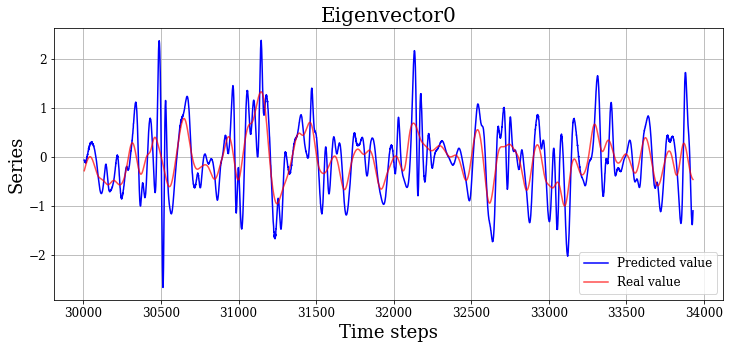

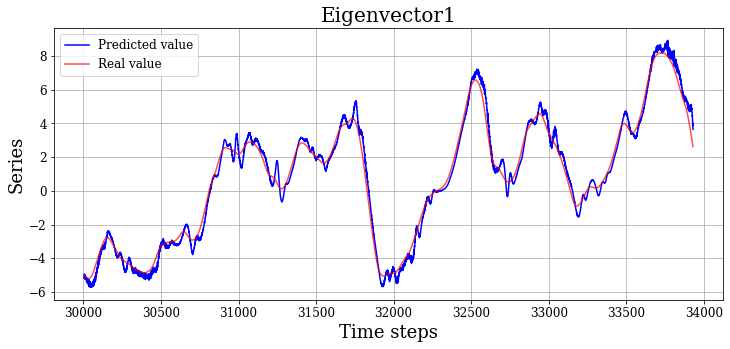

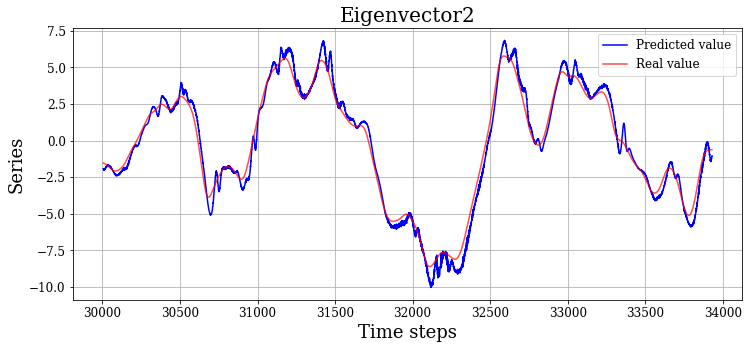

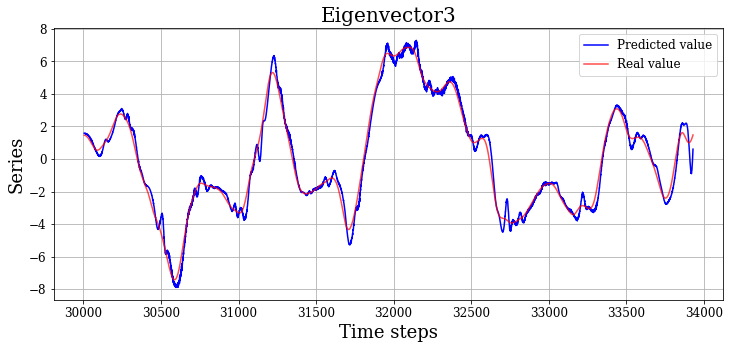

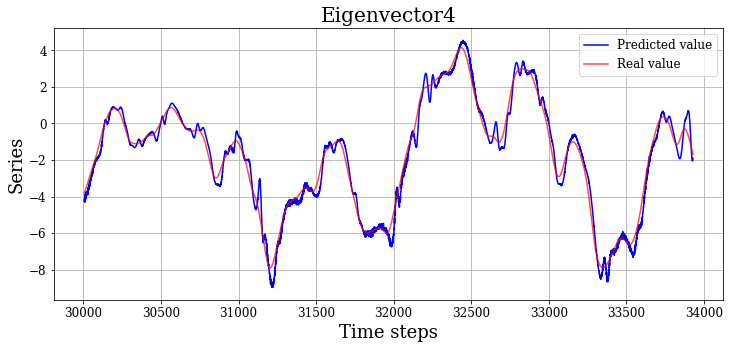

In [43]:
# Plot comparison for test dataset - first eigenvectors

for i in tqdm(range(5)):
    
    l = load_model('trained_models/' + str(i), verbose=False)
    p = predict_model(l, data=dataframe_test)
    
    dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON) 
    dataframe_train = dataframe[:30000]
    dataframe_test = dataframe[30000:]  
    
    plt.figure(figsize=(12,5))
    
    plt.plot(p['Label'],color='blue',label='Predicted value')
    plt.plot(p[dataframe.columns[-1]],color='red',alpha=0.7,label='Real value')
    
    plt.title('Eigenvector' + str(i))
    plt.xlabel('Time steps')
    plt.ylabel('Series')
    plt.legend()
    #plt.xlim([30000,34000])
    #plt.ylim([-10,9])
    plt.grid()

100%|██████████| 5/5 [00:00<00:00,  8.49it/s]


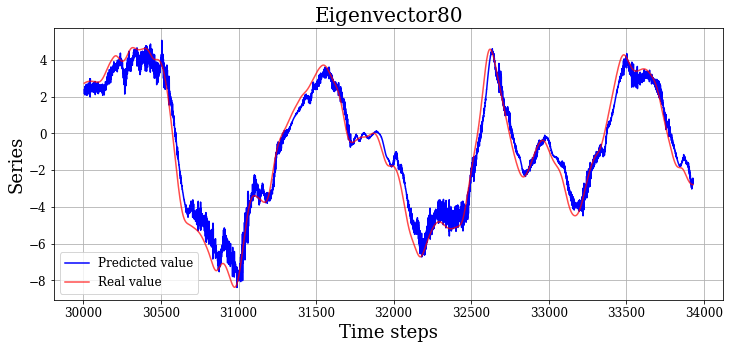

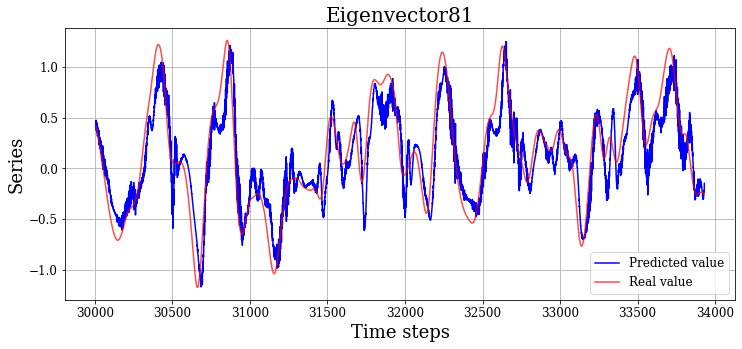

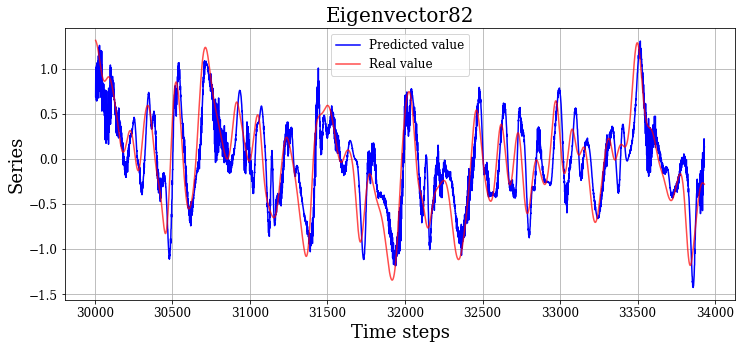

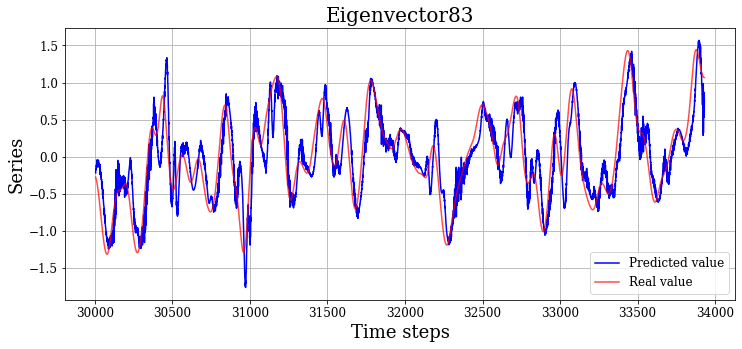

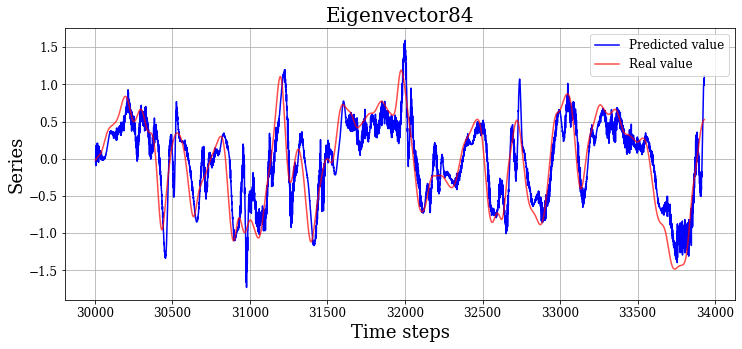

In [44]:
# Plot comparison for test dataset - last few eigenvectors

for i in tqdm(range(5)):
    
    i = i + 80
    l = load_model('trained_models/' + str(i), verbose=False)
    p = predict_model(l, data=dataframe_test)
    
    dataframe = create_dataset(df,i,nlags=NLAGS,HORIZON=HORIZON) 
    dataframe_train = dataframe[:30000]
    dataframe_test = dataframe[30000:]  
    
    plt.figure(figsize=(12,5))
    
    plt.plot(p['Label'],color='blue',label='Predicted value')
    plt.plot(p[dataframe.columns[-1]],color='red',alpha=0.7,label='Real value')
    
    plt.title('Eigenvector' + str(i))
    plt.xlabel('Time steps')
    plt.ylabel('Series')
    plt.legend()
    #plt.xlim([30000,34000])
    #plt.ylim([-10,9])
    plt.grid()

In [45]:
predicted_time_series = concat_df.loc[:,concat_df.columns == 'Label']
print(predicted_time_series.shape)
predicted_time_series.columns = ['Eigenvector' + str(i) for i in range(df.shape[1])]
predicted_time_series

(3926, 94)


,Eigenvector0,Eigenvector1,Eigenvector2,Eigenvector3,Eigenvector4,Eigenvector5,Eigenvector6,Eigenvector7,Eigenvector8,Eigenvector9,...,Eigenvector84,Eigenvector85,Eigenvector86,Eigenvector87,Eigenvector88,Eigenvector89,Eigenvector90,Eigenvector91,Eigenvector92,Eigenvector93
30005,-4.045229,-1.793465,1.606808,-4.058432,2.579162,1.727442,2.284880,5.819274,-1.428281,1.243899,...,-0.384896,0.011363,0.037007,0.639035,0.286720,0.337302,0.613010,0.282662,-0.064960,-0.361511
30006,-4.278318,-1.817473,1.606599,-4.204397,2.650107,1.749078,2.393721,5.723814,-1.408382,1.234143,...,-0.402869,0.063511,0.006732,0.667847,0.037074,0.450087,0.530890,0.273611,0.246139,-0.296615
30007,-3.983188,-1.842765,1.604772,-4.087056,2.712858,1.790559,2.241055,5.711415,-1.377269,1.202941,...,-0.402870,-0.118469,0.000863,0.567448,0.315731,0.330252,0.640486,0.276747,-0.085441,-0.407243
30008,-4.190625,-1.885398,1.607388,-4.031845,2.582795,1.827390,2.414268,5.585896,-1.442618,1.280957,...,-0.396825,0.174292,0.017282,0.597444,0.083213,0.367134,0.582692,0.268405,0.159165,-0.286175
30009,-4.201367,-1.861459,1.607398,-3.984427,2.699847,1.865338,2.418967,5.723056,-1.407172,1.212409,...,-0.363976,-0.021537,0.022083,0.768928,0.275415,0.454191,0.648015,0.287790,0.062311,-0.320581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33926,3.217070,-1.198008,-0.034078,-2.236740,-3.436265,-2.233222,1.683784,7.132162,-0.578123,1.431633,...,0.592979,0.867577,-0.692532,0.386214,-0.383814,-0.783982,-0.410873,-0.706377,0.277139,-0.424326
33927,2.926282,-1.187786,0.132618,-2.244687,-3.295614,-2.314949,1.757421,7.328446,-0.662835,1.504351,...,0.703541,0.690871,-0.641830,0.837617,-0.368124,-0.807967,-0.401025,-0.681247,0.231608,-0.388931
33928,2.656556,-1.133790,0.354857,-2.208292,-3.260777,-2.391052,1.777166,7.142324,-0.744839,1.635308,...,0.687916,0.759387,-0.647764,0.285138,-0.384018,-0.809941,-0.378903,-0.643395,0.190530,-0.392597
33929,2.811627,-0.992967,0.586069,-2.148474,-3.169925,-2.472522,1.736496,7.482312,-0.858303,1.780827,...,0.577482,0.629960,-0.624335,0.823390,-0.581116,-0.819219,-0.503045,-0.605762,0.234536,-0.341855


# Visualizing the Kuramoto equation from model prediction

In [46]:
y_test_forecast = pca2.inverse_transform(predicted_time_series) # Returning the 93 time series back into the problem series 
y_test_forecast.shape

(3926, 256)

In [47]:
y_test_forecast = pd.DataFrame(y_test_forecast)
yhat = scaler2.inverse_transform(y_test_forecast)

In [48]:
# Remove first row from all dataframes to correctly compare results

X_test2 = X[-y_test_forecast.shape[0]:]
T_test2 = T[-y_test_forecast.shape[0]:]
U_test2 = U[-y_test_forecast.shape[0]:]
U_test_reduced2 = U_test_reduced_inverse[-y_test_forecast.shape[0]:]

0.23908969693944962


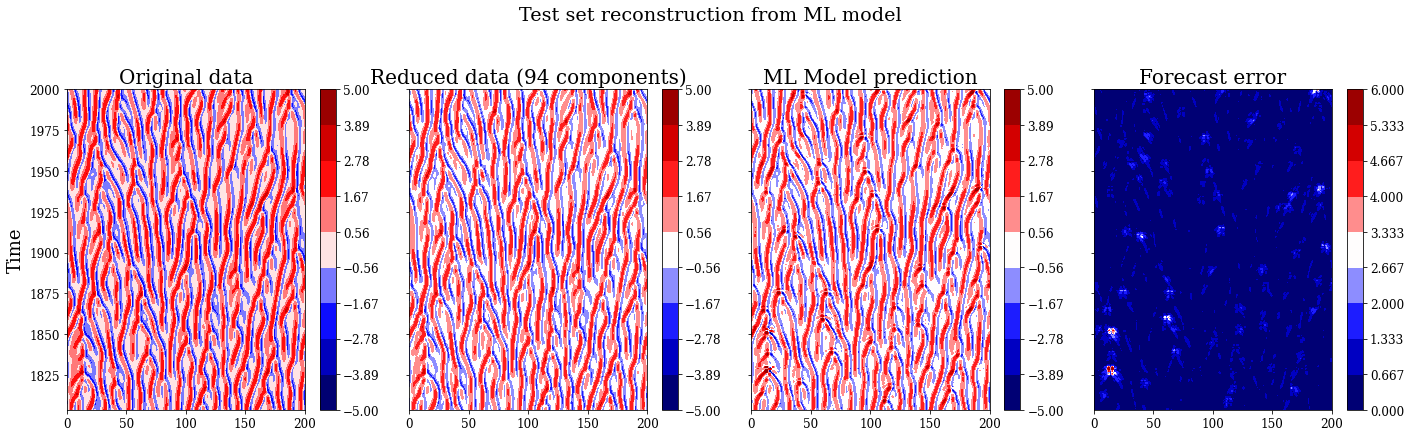

In [49]:
fig, ax = plt.subplots(1,4,sharey=True,figsize=(20, 6))
plt.suptitle('Test set reconstruction from ML model', y=1.02)

vmin = -5
vmax = 5
levels = np.linspace(vmin, vmax, 10)

surf1 = ax[0].contourf(X_test2, T_test2,U_test2,cmap=plt.get_cmap("seismic",20), vmin=vmin, vmax=vmax,levels=levels)
ax[0].set_title('Original data')
ax[0].set_ylabel('Time')

surf2 = ax[1].contourf(X_test2, T_test2, U_test_reduced2,cmap=plt.get_cmap("seismic"), vmin=vmin, vmax=vmax,levels=levels)
ax[1].set_title('Reduced data ({} components)'.format(d))

surf3 = ax[2].contourf(X_test2, T_test2, yhat,cmap=plt.get_cmap("seismic"), vmin=vmin, vmax=vmax,levels=levels)
ax[2].set_title('ML Model prediction')

diff = abs(yhat-U_test2)
surf4 = ax[3].contourf(X_test2,  T_test2, diff,cmap=plt.get_cmap("seismic"), vmin=0, vmax=6,levels=np.linspace(0, 6, 10))
ax[3].set_title('Forecast error')

plt.colorbar(surf1, ax=ax[0])
plt.colorbar(surf2, ax=ax[1])
plt.colorbar(surf3, ax=ax[2])
plt.colorbar(surf4, ax=ax[3])


plt.tight_layout()

print(diff.mean())

- Test set error from reduced components (using 93 instead of 256): 0.1809 
- Test set error from model prediction: 0.2391

# Conclusions:

- Defining time series forecasting as a **supervised** learning problem is very complicated in this case due the extensive feature engineering (create lag features) and dificulty in training various models. 

- Deep learning techniques would automatically learn the feature mapping between input and output. Even more, we would not have to create a model for each individual time series. This should lead to a more elegant solution and hopefully the MAE continues to be low.

- Statistical models such as ARIMA might provide similiar results without us having to worry about the lag terms since a grid search involving this function will provide us these optimal hyperparameters. The trouble of forecasting all individual time series would remain however (I believe). This should be tested later on as well. 

- The model can forecast 70 time steps (17.5) seconds into the future with good accuracy (comparable to the PCA test set error). When we get to around 100 time steps, the model performance is not good enough for forecasting.